In [1]:
 #mounting to google drive for file

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

# check if the zip file is here
!ls /content/drive/MyDrive/Colab\ Notebooks/


'archive (4).zip'			      hillclimbing.ipynb
'CNN_(3)_(1)_(1)_(1)_(1)_(1)_(2) (4).ipynb'   idlmam.py
'CNN_(3)_(1)_(1)_(1)_(1)_(1) (2).ipynb'       __pycache__
'CNN_(3)_(1)_(1)_(1) (1) (1).ipynb'	      RNN.ipynb
'CNN_(3)_(1)_(1)_(1)_(1) (1).ipynb'	      Untitled
'CNN_(3)_(1)_(1)_(1)_(1) (2).ipynb'	     'Untitled (1)'
'CNN_(3)_(1)_(1)_(1)_(1) (3).ipynb'	     'Untitled (2)'
'CNN_(3)_(1)_(1)_(1) (1).ipynb'		     'Untitled (3)'
'CNN_(3)_(1)_(1)_(1)_(1).ipynb'		     'Untitled (4)'
'CNN_(3)_(1)_(1) (1).ipynb'		     'Untitled (5)'
'CNN_(3)_(1)_(1).ipynb'			     'Untitled (6)'
'CNN_(3) (1).ipynb'			     'Untitled (7)'
'CNN_(3)_(1).ipynb'			     'Untitled (8)'
'CNN_final_final_(3)_(1)_(1) (2).ipynb'      'Week01_IntroToPyTorch (1).ipynb'
'CNN final.ipynb'			      Week01_IntroToPyTorch.ipynb
'Copy of CNN_final_final (3).ipynb'	      Week02_Exercises.ipynb
'Copy of CNN.ipynb'			      Week02_PyTorchII.ipynb
'Copy of Copy of CNN_final_final (3).ipynb'   Week07_CNN_II_Exercise.ipynb


In [3]:

#unzip the file
!unzip "/content/drive/MyDrive/Colab Notebooks/archive (4).zip" -d "/content/asl_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_

In [4]:
#check what is inside the file
!ls /content/asl_dataset


ASL_Alphabet_Dataset


In [5]:

#imports
import torchvision
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader,Subset,random_split
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import SGD
import random
import os
import shutil
from google.colab import files
from PIL import Image
import json

In [6]:
# check training directory
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train



A  B  C  D  del  E  F  G  H  I	J  K  L  M  N  nothing	O  P  Q  R  S  space  T  U  V  W  X  Y	Z


In [7]:
# Check for CUDA device
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [8]:
#reesize to 64x64 and normalize to [1,-1]
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load the dataset
dataset = datasets.ImageFolder('/content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train', transform=transform)

#20% training dataset which is like 44614 and 6% validation which is 13384 enought data so do not need to augment.It is to make sure that the training does not take too long
train_percentage = 0.2
val_percentage = 0.06
train = int(train_percentage * len(dataset))
val = int(val_percentage * len(dataset))
unuse = len(dataset) - train - val# the amount that we are not using
# train_subset is 20% val_dataset is 6%  and _ unused data
train_subset, val_dataset, _ = random_split(dataset, [train, val, unuse])

# dataloaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
print(f"Training dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 44614
Validation dataset size: 13384


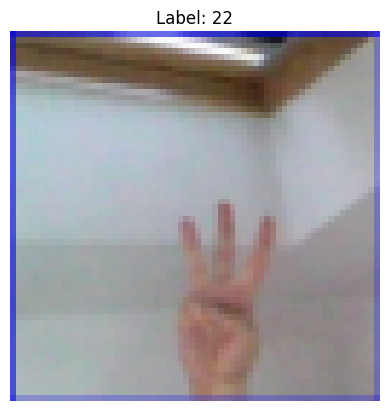

In [9]:
#convert train loader into a iterator which allows us to manually retrive a 1 single batch
iter = iter(train_loader)
images, labels = next(iter)

# unnormalize the first image back to [0, 1] becuase normalized image pixel values are not suitable for direct visualization.
image = images[0] * 0.5 + 0.5
image = image.numpy().transpose((1, 2, 0))
# Plot the image
plt.imshow(image)
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()

In [10]:
class asl(nn.Module):
    def __init__(self, num_classes=29):
        super(asl, self).__init__()

        # 3 convolutional layers with max pooling, and dropout (feature extraction input 64 x 64x 3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        # Fully connected layers with fixed sizes matching the trained model
        self.fc1 = nn.Linear(8192, 512)  # 8192 passed from the last conv layer
        self.fc2 = nn.Linear(512, num_classes)

    #defines how the data moves through the model
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)# reduce it in half becomes 32 x32 x32 becuase half weight and height
        x = self.relu(self.conv2(x))
        x = self.pool(x)# reduce it in half becomes 16 x16 x64 becuase half weight and height
        x = self.relu(self.conv3(x))
        x = self.pool(x)# reduce it in half becomes 8 x8 x128 becuase half weight and height

        x = x.view(x.size(0), -1)  # flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
#func to modulirise training of optimizer
def optimizer_train(optimizer_name, optimizer_class, model, train_loader, num_epochs=20, **optimizer_params):
    print(f"\nTraining with {optimizer_name} optimizer...")
    model = asl(num_classes=29).to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    #loss func choosen cause classification
    loss_func = nn.CrossEntropyLoss()
    model.train()
    # loss and accuracy
    loss_history = []
    accuracy_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        #progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            #pass throught the model
            outputs = model(inputs)
            loss = loss_func(outputs, labels)  #  compare predicted to actual class socres
            # backpropergate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # calculate the number of correct predictions in the batch
            _, predicted = outputs.max(1)  # get class with max probability
            total += labels.size(0)  # total number of samples
            correct += predicted.eq(labels).sum().item()  # count correct predictions
            progress_bar.set_postfix(loss=(running_loss / len(train_loader)))

        # calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)
        print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

    # return the loss and accuracy
    return loss_history, accuracy_history




i want to see which optimizer gives me the best accuracy with the lowest noise so that i can apply the best optimizer for this

Stocastic gradient descent

In [ ]:
optimizer_name = "SGD"
optimizer_class = SGD
params = {"lr": 0.001}
batch_size = 1  # SGD uses batch size 1
num_samples_per_epoch = 1000  # random samples to process in each epoch
loss_history = []
accuracy_history = []


model = asl(num_classes=29)
for epoch in range(20):  #20 epoch
    # randomly sample for each epoch
    random_indice = random.sample(range(len(train_subset)), num_samples_per_epoch)
    sampled_subset = Subset(train_subset, random_indice)
    optimizer_train_loader = DataLoader(sampled_subset, batch_size=batch_size, shuffle=True)
    #calling the training for the optimizer
    epoch_loss_history, epoch_accuracy_history = optimizer_train(
        optimizer_name, optimizer_class, model, optimizer_train_loader, num_epochs=1, **params
    )
    loss_history.extend(epoch_loss_history)
    accuracy_history.extend(epoch_accuracy_history)

results_sgd = {"loss": loss_history, "accuracy": accuracy_history}



Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:10<00:00, 99.34batch/s, loss=3.37]


Epoch 1: Loss = 3.3661, Accuracy = 0.0350

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:09<00:00, 109.74batch/s, loss=3.37]


Epoch 1: Loss = 3.3655, Accuracy = 0.0360

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 114.12batch/s, loss=3.37]


Epoch 1: Loss = 3.3663, Accuracy = 0.0310

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 121.88batch/s, loss=3.37]


Epoch 1: Loss = 3.3665, Accuracy = 0.0460

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 113.71batch/s, loss=3.37]


Epoch 1: Loss = 3.3660, Accuracy = 0.0280

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 125.83batch/s, loss=3.37]


Epoch 1: Loss = 3.3651, Accuracy = 0.0410

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 115.78batch/s, loss=3.37]


Epoch 1: Loss = 3.3688, Accuracy = 0.0350

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 125.96batch/s, loss=3.36]


Epoch 1: Loss = 3.3645, Accuracy = 0.0440

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 115.61batch/s, loss=3.37]


Epoch 1: Loss = 3.3654, Accuracy = 0.0430

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 127.13batch/s, loss=3.36]


Epoch 1: Loss = 3.3645, Accuracy = 0.0400

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 113.74batch/s, loss=3.36]


Epoch 1: Loss = 3.3650, Accuracy = 0.0500

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 116.83batch/s, loss=3.37]


Epoch 1: Loss = 3.3666, Accuracy = 0.0330

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 121.74batch/s, loss=3.37]


Epoch 1: Loss = 3.3669, Accuracy = 0.0270

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 115.55batch/s, loss=3.37]


Epoch 1: Loss = 3.3669, Accuracy = 0.0390

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 133.18batch/s, loss=3.36]


Epoch 1: Loss = 3.3650, Accuracy = 0.0450

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 114.99batch/s, loss=3.37]


Epoch 1: Loss = 3.3663, Accuracy = 0.0380

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 133.47batch/s, loss=3.37]


Epoch 1: Loss = 3.3650, Accuracy = 0.0350

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 115.72batch/s, loss=3.37]


Epoch 1: Loss = 3.3682, Accuracy = 0.0240

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 127.30batch/s, loss=3.37]


Epoch 1: Loss = 3.3667, Accuracy = 0.0380

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 115.16batch/s, loss=3.37]

Epoch 1: Loss = 3.3671, Accuracy = 0.0350


mini batch gradient descent

In [ ]:
optimizer_name = "Mini-batch Gradient Descent (MBGD)"
optimizer_class = SGD
params = {"lr": 0.001}
batch_size = 64  # bigger batch size becuase train in small groups


optimizer_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
loss_history, accuracy_history = optimizer_train(
    optimizer_name, optimizer_class, asl(num_classes=29), optimizer_train_loader, num_epochs=20, **params
)


results_mbgd = {"loss": loss_history, "accuracy": accuracy_history}



Training with Mini-batch Gradient Descent (MBGD) optimizer...


Epoch 1/20: 100%|██████████| 698/698 [01:50<00:00,  6.30batch/s, loss=3.37]


Epoch 1: Loss = 3.3653, Accuracy = 0.0412


Epoch 2/20: 100%|██████████| 698/698 [01:30<00:00,  7.72batch/s, loss=3.36]


Epoch 2: Loss = 3.3601, Accuracy = 0.0426


Epoch 3/20: 100%|██████████| 698/698 [01:30<00:00,  7.68batch/s, loss=3.35]


Epoch 3: Loss = 3.3547, Accuracy = 0.0457


Epoch 4/20: 100%|██████████| 698/698 [01:31<00:00,  7.66batch/s, loss=3.35]


Epoch 4: Loss = 3.3479, Accuracy = 0.0509


Epoch 5/20: 100%|██████████| 698/698 [01:29<00:00,  7.78batch/s, loss=3.34]


Epoch 5: Loss = 3.3383, Accuracy = 0.0579


Epoch 6/20: 100%|██████████| 698/698 [01:32<00:00,  7.58batch/s, loss=3.32]


Epoch 6: Loss = 3.3226, Accuracy = 0.0689


Epoch 7/20: 100%|██████████| 698/698 [01:29<00:00,  7.76batch/s, loss=3.29]


Epoch 7: Loss = 3.2935, Accuracy = 0.0781


Epoch 8/20: 100%|██████████| 698/698 [01:29<00:00,  7.80batch/s, loss=3.24]


Epoch 8: Loss = 3.2364, Accuracy = 0.0960


Epoch 9/20: 100%|██████████| 698/698 [01:29<00:00,  7.77batch/s, loss=3.14]


Epoch 9: Loss = 3.1424, Accuracy = 0.1181


Epoch 10/20: 100%|██████████| 698/698 [01:28<00:00,  7.89batch/s, loss=3.04]


Epoch 10: Loss = 3.0408, Accuracy = 0.1451


Epoch 11/20: 100%|██████████| 698/698 [01:30<00:00,  7.75batch/s, loss=2.93]


Epoch 11: Loss = 2.9304, Accuracy = 0.1767


Epoch 12/20: 100%|██████████| 698/698 [01:27<00:00,  7.95batch/s, loss=2.8]


Epoch 12: Loss = 2.7981, Accuracy = 0.2111


Epoch 13/20: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=2.65]


Epoch 13: Loss = 2.6504, Accuracy = 0.2463


Epoch 14/20: 100%|██████████| 698/698 [01:29<00:00,  7.81batch/s, loss=2.5]


Epoch 14: Loss = 2.4990, Accuracy = 0.2811


Epoch 15/20: 100%|██████████| 698/698 [01:29<00:00,  7.76batch/s, loss=2.36]


Epoch 15: Loss = 2.3585, Accuracy = 0.3160


Epoch 16/20: 100%|██████████| 698/698 [01:30<00:00,  7.74batch/s, loss=2.22]


Epoch 16: Loss = 2.2232, Accuracy = 0.3464


Epoch 17/20: 100%|██████████| 698/698 [01:28<00:00,  7.84batch/s, loss=2.1]


Epoch 17: Loss = 2.0990, Accuracy = 0.3777


Epoch 18/20: 100%|██████████| 698/698 [01:29<00:00,  7.80batch/s, loss=1.98]


Epoch 18: Loss = 1.9786, Accuracy = 0.4112


Epoch 19/20: 100%|██████████| 698/698 [01:29<00:00,  7.78batch/s, loss=1.87]


Epoch 19: Loss = 1.8709, Accuracy = 0.4412


Epoch 20/20: 100%|██████████| 698/698 [01:27<00:00,  7.99batch/s, loss=1.76]

Epoch 20: Loss = 1.7593, Accuracy = 0.4732


gradient descent cant be run as the processing of the entire dataset exceeds the memory capacity of the GPU

In [ ]:
optimizer_name = "Adam"
optimizer_class = optim.Adam
params = {"lr": 0.001}
batch_size = 64


optimizer_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
loss_history, accuracy_history = optimizer_train(
    optimizer_name, optimizer_class, asl(num_classes=29), optimizer_train_loader, num_epochs=20, **params
)
results_adam = {"loss": loss_history, "accuracy": accuracy_history}



Training with Adam optimizer...


Epoch 1/20: 100%|██████████| 698/698 [01:30<00:00,  7.68batch/s, loss=1.43]


Epoch 1: Loss = 1.4334, Accuracy = 0.5634


Epoch 2/20: 100%|██████████| 698/698 [01:28<00:00,  7.89batch/s, loss=0.416]


Epoch 2: Loss = 0.4161, Accuracy = 0.8674


Epoch 3/20: 100%|██████████| 698/698 [01:29<00:00,  7.83batch/s, loss=0.224]


Epoch 3: Loss = 0.2243, Accuracy = 0.9275


Epoch 4/20: 100%|██████████| 698/698 [01:30<00:00,  7.75batch/s, loss=0.154]


Epoch 4: Loss = 0.1543, Accuracy = 0.9496


Epoch 5/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.12]


Epoch 5: Loss = 0.1205, Accuracy = 0.9603


Epoch 6/20: 100%|██████████| 698/698 [01:30<00:00,  7.75batch/s, loss=0.0946]


Epoch 6: Loss = 0.0946, Accuracy = 0.9702


Epoch 7/20: 100%|██████████| 698/698 [01:29<00:00,  7.82batch/s, loss=0.0844]


Epoch 7: Loss = 0.0844, Accuracy = 0.9729


Epoch 8/20: 100%|██████████| 698/698 [01:30<00:00,  7.72batch/s, loss=0.0718]


Epoch 8: Loss = 0.0718, Accuracy = 0.9758


Epoch 9/20: 100%|██████████| 698/698 [01:29<00:00,  7.83batch/s, loss=0.0655]


Epoch 9: Loss = 0.0655, Accuracy = 0.9789


Epoch 10/20: 100%|██████████| 698/698 [01:30<00:00,  7.69batch/s, loss=0.0628]


Epoch 10: Loss = 0.0628, Accuracy = 0.9796


Epoch 11/20: 100%|██████████| 698/698 [01:30<00:00,  7.71batch/s, loss=0.0551]


Epoch 11: Loss = 0.0551, Accuracy = 0.9824


Epoch 12/20: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=0.0482]


Epoch 12: Loss = 0.0482, Accuracy = 0.9845


Epoch 13/20: 100%|██████████| 698/698 [01:31<00:00,  7.64batch/s, loss=0.0512]


Epoch 13: Loss = 0.0512, Accuracy = 0.9844


Epoch 14/20: 100%|██████████| 698/698 [01:29<00:00,  7.78batch/s, loss=0.0426]


Epoch 14: Loss = 0.0426, Accuracy = 0.9866


Epoch 15/20: 100%|██████████| 698/698 [01:30<00:00,  7.73batch/s, loss=0.0369]


Epoch 15: Loss = 0.0369, Accuracy = 0.9881


Epoch 16/20: 100%|██████████| 698/698 [01:29<00:00,  7.84batch/s, loss=0.0461]


Epoch 16: Loss = 0.0461, Accuracy = 0.9858


Epoch 17/20: 100%|██████████| 698/698 [01:29<00:00,  7.78batch/s, loss=0.0348]


Epoch 17: Loss = 0.0348, Accuracy = 0.9890


Epoch 18/20: 100%|██████████| 698/698 [01:30<00:00,  7.74batch/s, loss=0.0371]


Epoch 18: Loss = 0.0371, Accuracy = 0.9887


Epoch 19/20: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=0.0354]


Epoch 19: Loss = 0.0354, Accuracy = 0.9892


Epoch 20/20: 100%|██████████| 698/698 [01:30<00:00,  7.73batch/s, loss=0.0331]

Epoch 20: Loss = 0.0331, Accuracy = 0.9894


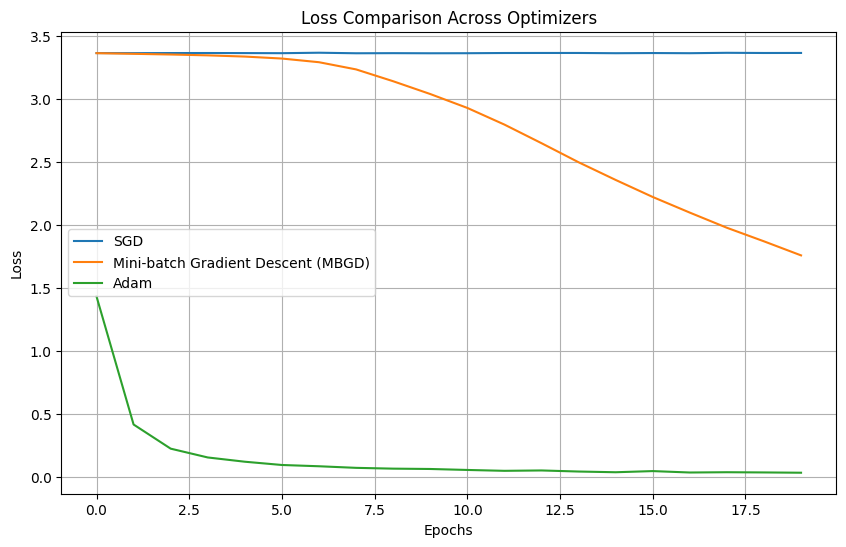

In [ ]:
# plot the loss
results = {
    "SGD": results_sgd,
    "Mini-batch Gradient Descent (MBGD)": results_mbgd,
    "Adam": results_adam
}

plt.figure(figsize=(10, 6))
for optimizer_name, result in results.items():
    plt.plot(result["loss"], label=optimizer_name)

plt.title('Loss Comparison Across Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

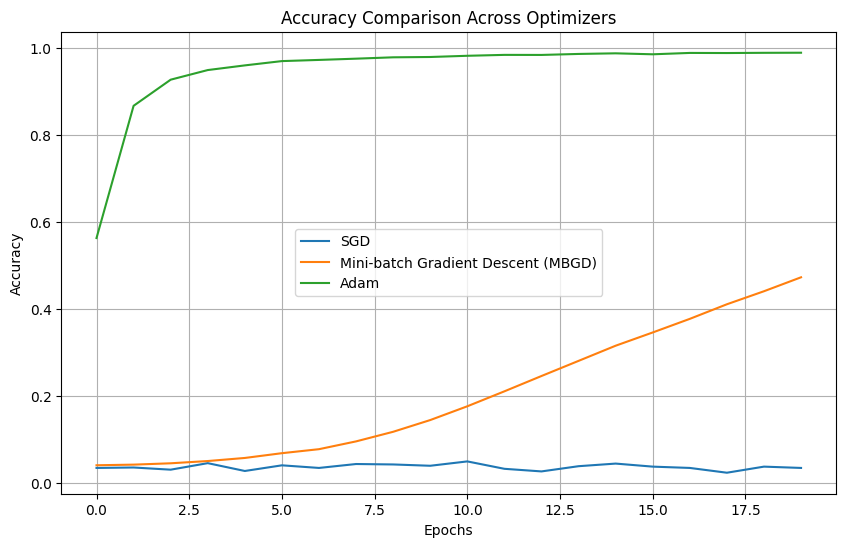

In [ ]:
# plot the accuracy
plt.figure(figsize=(10, 6))

for optimizer_name, result in results.items():
    plt.plot(result["accuracy"], label=optimizer_name)

plt.title('Accuracy Comparison Across Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

the accuracy shows that adam is the most accurate among the 3 algorithm  and also has the least loss meaning that it is closest to the actual values as compared to the rest

since now we know that adam is the best in terms of accuracy and loss we now have to tune the learning rate and decide which is the best for adam and make sure to prevent overfitting and underfitting

In [ ]:
#compare the different  lr to see which the best
def train_learning_rates(model_class, train_loader, num_epochs, learning_rates, device):
    results = {}

    for lr in learning_rates:
        print(f"\nTraining with MBGD optimizer and learning rate = {lr}...")
        model = model_class(num_classes=29).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_func = nn.CrossEntropyLoss()
        model.train()
        loss_history = []
        accuracy_history = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                progress_bar.set_postfix(loss=(running_loss / len(train_loader)))



            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct / total
            loss_history.append(epoch_loss)
            accuracy_history.append(epoch_accuracy)
            print(f"Learning Rate {lr} - Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")



        results[lr] = {"loss": loss_history, "accuracy": accuracy_history}
    return results


In [ ]:
learning_rates = [0.01, 0.001]  # cannot have too many as it takes too long to train
num_epochs = 20

results_adam_lr = train_learning_rates(
    asl,
    train_loader,
    num_epochs,
    learning_rates,
    device
)



Training with MBGD optimizer and learning rate = 0.01...


Epoch 1/20: 100%|██████████| 698/698 [02:08<00:00,  5.43batch/s, loss=1.98]


Learning Rate 0.01 - Epoch 1: Loss = 1.9805, Accuracy = 0.4400


Epoch 2/20: 100%|██████████| 698/698 [01:34<00:00,  7.40batch/s, loss=0.928]


Learning Rate 0.01 - Epoch 2: Loss = 0.9284, Accuracy = 0.7139


Epoch 3/20: 100%|██████████| 698/698 [01:29<00:00,  7.78batch/s, loss=0.716]


Learning Rate 0.01 - Epoch 3: Loss = 0.7163, Accuracy = 0.7779


Epoch 4/20: 100%|██████████| 698/698 [01:30<00:00,  7.74batch/s, loss=0.611]


Learning Rate 0.01 - Epoch 4: Loss = 0.6105, Accuracy = 0.8100


Epoch 5/20: 100%|██████████| 698/698 [01:29<00:00,  7.82batch/s, loss=0.553]


Learning Rate 0.01 - Epoch 5: Loss = 0.5526, Accuracy = 0.8262


Epoch 6/20: 100%|██████████| 698/698 [01:29<00:00,  7.78batch/s, loss=0.506]


Learning Rate 0.01 - Epoch 6: Loss = 0.5058, Accuracy = 0.8435


Epoch 7/20: 100%|██████████| 698/698 [01:36<00:00,  7.26batch/s, loss=0.478]


Learning Rate 0.01 - Epoch 7: Loss = 0.4784, Accuracy = 0.8485


Epoch 8/20: 100%|██████████| 698/698 [01:34<00:00,  7.41batch/s, loss=0.449]


Learning Rate 0.01 - Epoch 8: Loss = 0.4490, Accuracy = 0.8591


Epoch 9/20: 100%|██████████| 698/698 [01:36<00:00,  7.24batch/s, loss=0.413]


Learning Rate 0.01 - Epoch 9: Loss = 0.4132, Accuracy = 0.8703


Epoch 10/20: 100%|██████████| 698/698 [01:31<00:00,  7.65batch/s, loss=0.402]


Learning Rate 0.01 - Epoch 10: Loss = 0.4015, Accuracy = 0.8756


Epoch 11/20: 100%|██████████| 698/698 [01:31<00:00,  7.60batch/s, loss=0.372]


Learning Rate 0.01 - Epoch 11: Loss = 0.3719, Accuracy = 0.8840


Epoch 12/20: 100%|██████████| 698/698 [01:29<00:00,  7.81batch/s, loss=0.39]


Learning Rate 0.01 - Epoch 12: Loss = 0.3903, Accuracy = 0.8773


Epoch 13/20: 100%|██████████| 698/698 [01:32<00:00,  7.51batch/s, loss=0.363]


Learning Rate 0.01 - Epoch 13: Loss = 0.3628, Accuracy = 0.8862


Epoch 14/20: 100%|██████████| 698/698 [01:39<00:00,  6.99batch/s, loss=0.34]


Learning Rate 0.01 - Epoch 14: Loss = 0.3399, Accuracy = 0.8931


Epoch 15/20: 100%|██████████| 698/698 [01:37<00:00,  7.18batch/s, loss=0.351]


Learning Rate 0.01 - Epoch 15: Loss = 0.3511, Accuracy = 0.8923


Epoch 16/20: 100%|██████████| 698/698 [01:34<00:00,  7.40batch/s, loss=0.349]


Learning Rate 0.01 - Epoch 16: Loss = 0.3487, Accuracy = 0.8936


Epoch 17/20: 100%|██████████| 698/698 [01:34<00:00,  7.35batch/s, loss=0.329]


Learning Rate 0.01 - Epoch 17: Loss = 0.3289, Accuracy = 0.8989


Epoch 18/20: 100%|██████████| 698/698 [01:34<00:00,  7.41batch/s, loss=0.329]


Learning Rate 0.01 - Epoch 18: Loss = 0.3289, Accuracy = 0.8984


Epoch 19/20: 100%|██████████| 698/698 [01:32<00:00,  7.53batch/s, loss=0.316]


Learning Rate 0.01 - Epoch 19: Loss = 0.3160, Accuracy = 0.9021


Epoch 20/20: 100%|██████████| 698/698 [01:35<00:00,  7.34batch/s, loss=0.326]


Learning Rate 0.01 - Epoch 20: Loss = 0.3258, Accuracy = 0.9018

Training with MBGD optimizer and learning rate = 0.001...


Epoch 1/20: 100%|██████████| 698/698 [01:33<00:00,  7.50batch/s, loss=1.26]


Learning Rate 0.001 - Epoch 1: Loss = 1.2582, Accuracy = 0.6211


Epoch 2/20: 100%|██████████| 698/698 [01:34<00:00,  7.40batch/s, loss=0.303]


Learning Rate 0.001 - Epoch 2: Loss = 0.3025, Accuracy = 0.9054


Epoch 3/20: 100%|██████████| 698/698 [01:34<00:00,  7.41batch/s, loss=0.167]


Learning Rate 0.001 - Epoch 3: Loss = 0.1670, Accuracy = 0.9469


Epoch 4/20: 100%|██████████| 698/698 [01:35<00:00,  7.35batch/s, loss=0.111]


Learning Rate 0.001 - Epoch 4: Loss = 0.1109, Accuracy = 0.9648


Epoch 5/20: 100%|██████████| 698/698 [01:34<00:00,  7.41batch/s, loss=0.0953]


Learning Rate 0.001 - Epoch 5: Loss = 0.0953, Accuracy = 0.9700


Epoch 6/20: 100%|██████████| 698/698 [01:35<00:00,  7.33batch/s, loss=0.0758]


Learning Rate 0.001 - Epoch 6: Loss = 0.0758, Accuracy = 0.9767


Epoch 7/20: 100%|██████████| 698/698 [01:33<00:00,  7.44batch/s, loss=0.0604]


Learning Rate 0.001 - Epoch 7: Loss = 0.0604, Accuracy = 0.9809


Epoch 8/20: 100%|██████████| 698/698 [01:34<00:00,  7.36batch/s, loss=0.0562]


Learning Rate 0.001 - Epoch 8: Loss = 0.0562, Accuracy = 0.9824


Epoch 9/20: 100%|██████████| 698/698 [01:33<00:00,  7.50batch/s, loss=0.0522]


Learning Rate 0.001 - Epoch 9: Loss = 0.0522, Accuracy = 0.9847


Epoch 10/20: 100%|██████████| 698/698 [01:33<00:00,  7.45batch/s, loss=0.0426]


Learning Rate 0.001 - Epoch 10: Loss = 0.0426, Accuracy = 0.9874


Epoch 11/20: 100%|██████████| 698/698 [01:34<00:00,  7.38batch/s, loss=0.0378]


Learning Rate 0.001 - Epoch 11: Loss = 0.0378, Accuracy = 0.9887


Epoch 12/20: 100%|██████████| 698/698 [01:33<00:00,  7.49batch/s, loss=0.0462]


Learning Rate 0.001 - Epoch 12: Loss = 0.0462, Accuracy = 0.9858


Epoch 13/20: 100%|██████████| 698/698 [01:34<00:00,  7.39batch/s, loss=0.0322]


Learning Rate 0.001 - Epoch 13: Loss = 0.0322, Accuracy = 0.9898


Epoch 14/20: 100%|██████████| 698/698 [01:33<00:00,  7.45batch/s, loss=0.0359]


Learning Rate 0.001 - Epoch 14: Loss = 0.0359, Accuracy = 0.9894


Epoch 15/20: 100%|██████████| 698/698 [01:34<00:00,  7.42batch/s, loss=0.033]


Learning Rate 0.001 - Epoch 15: Loss = 0.0330, Accuracy = 0.9907


Epoch 16/20: 100%|██████████| 698/698 [01:33<00:00,  7.48batch/s, loss=0.0258]


Learning Rate 0.001 - Epoch 16: Loss = 0.0258, Accuracy = 0.9924


Epoch 17/20: 100%|██████████| 698/698 [01:31<00:00,  7.64batch/s, loss=0.031]


Learning Rate 0.001 - Epoch 17: Loss = 0.0310, Accuracy = 0.9911


Epoch 18/20: 100%|██████████| 698/698 [01:32<00:00,  7.56batch/s, loss=0.0281]


Learning Rate 0.001 - Epoch 18: Loss = 0.0281, Accuracy = 0.9919


Epoch 19/20: 100%|██████████| 698/698 [01:31<00:00,  7.62batch/s, loss=0.0233]


Learning Rate 0.001 - Epoch 19: Loss = 0.0233, Accuracy = 0.9931


Epoch 20/20: 100%|██████████| 698/698 [01:31<00:00,  7.63batch/s, loss=0.0246]

Learning Rate 0.001 - Epoch 20: Loss = 0.0246, Accuracy = 0.9930


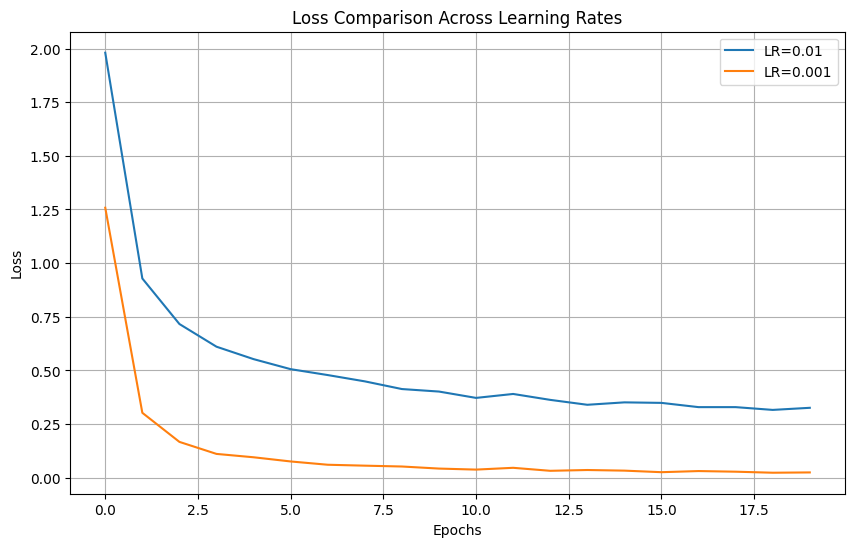

In [ ]:
#plot the loss
plt.figure(figsize=(10, 6))
for lr, result in results_adam_lr.items():
    plt.plot(result["loss"], label=f"LR={lr}")

plt.title('Loss Comparison Across Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




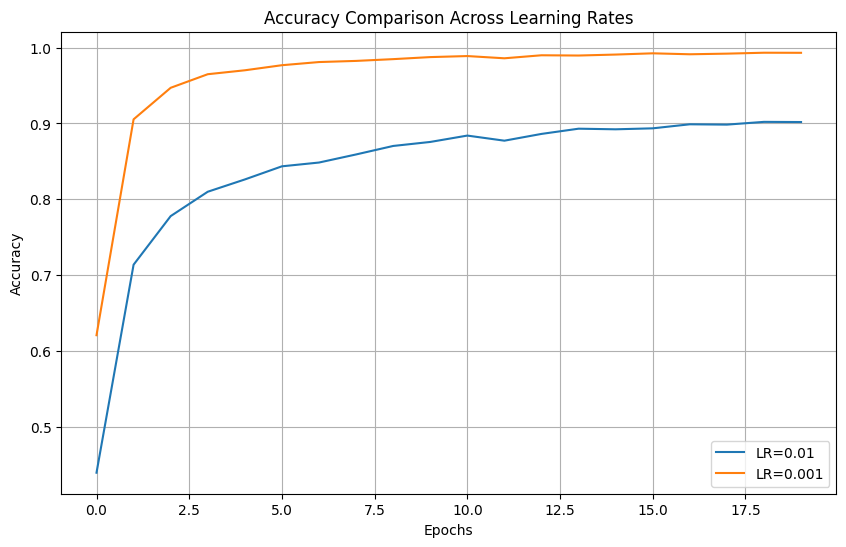

In [ ]:
#plot the accuracy
plt.figure(figsize=(10, 6))
for lr, result in results_adam_lr.items():
    plt.plot(result["accuracy"], label=f"LR={lr}")

plt.title('Accuracy Comparison Across Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

from this 2 graph we can see that 0.001 works best



so now we can train the training dataset and compare it against the validation dataset where we will be using adam and a lr of 0.001

after doing the advance part, i noticed that the prediction is almost all wrong dispite having good accuracy and loss and since it started plateuing i reduce the number of epoch to 10 to see how it far and it now predicts much better

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = asl(num_classes=29).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

num_epochs = 10
train_loss_history, val_loss_history = [], []
train_accuracy_history, val_accuracy_history = [], []
val_f1_score_history, val_precision_history, val_recall_history = [], [], []

for epoch in range(num_epochs):
    # training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)", unit="batch")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        progress_bar.set_postfix(loss=(running_loss / len(train_loader)))

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    # validation
    model.eval()#disable dropout
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad(): #disable calc of gradient since no need backpropergate
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", unit="batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)#get 1st predicted
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    #calc val loss, val accuracy, and confusion matrix
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)
    cm = confusion_matrix(all_labels, all_predictions)

    # calc f1score, precision, and recall
    val_f1 = f1_score(all_labels, all_predictions, average="macro")
    val_precision = precision_score(all_labels, all_predictions, average="macro", zero_division=0)
    val_recall = recall_score(all_labels, all_predictions, average="macro", zero_division=0)

    val_f1_score_history.append(val_f1)
    val_precision_history.append(val_precision)
    val_recall_history.append(val_recall)

    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}, "
          f"Val F1 Score = {val_f1:.4f}, Val Precision = {val_precision:.4f}, Val Recall = {val_recall:.4f}")


Epoch 1/10 (Validation): 100%|██████████| 210/210 [00:27<00:00,  7.65batch/s]


Epoch 1: Train Loss = 1.2548, Train Accuracy = 0.6193, Val Loss = 0.4276, Val Accuracy = 0.8727, Val F1 Score = 0.8769, Val Precision = 0.8836, Val Recall = 0.8755


Epoch 2/10 (Validation): 100%|██████████| 210/210 [00:25<00:00,  8.39batch/s]


Epoch 2: Train Loss = 0.3136, Train Accuracy = 0.9014, Val Loss = 0.2188, Val Accuracy = 0.9377, Val F1 Score = 0.9394, Val Precision = 0.9405, Val Recall = 0.9392


Epoch 3/10 (Validation): 100%|██████████| 210/210 [00:25<00:00,  8.10batch/s]


Epoch 3: Train Loss = 0.1678, Train Accuracy = 0.9454, Val Loss = 0.1638, Val Accuracy = 0.9545, Val F1 Score = 0.9557, Val Precision = 0.9560, Val Recall = 0.9558


Epoch 4/10 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.46batch/s]


Epoch 4: Train Loss = 0.1164, Train Accuracy = 0.9629, Val Loss = 0.1474, Val Accuracy = 0.9611, Val F1 Score = 0.9621, Val Precision = 0.9630, Val Recall = 0.9617


Epoch 5/10 (Validation): 100%|██████████| 210/210 [00:28<00:00,  7.32batch/s]


Epoch 5: Train Loss = 0.0945, Train Accuracy = 0.9701, Val Loss = 0.1366, Val Accuracy = 0.9655, Val F1 Score = 0.9664, Val Precision = 0.9667, Val Recall = 0.9666


Epoch 6/10 (Validation): 100%|██████████| 210/210 [00:27<00:00,  7.70batch/s]


Epoch 6: Train Loss = 0.0751, Train Accuracy = 0.9764, Val Loss = 0.1334, Val Accuracy = 0.9691, Val F1 Score = 0.9699, Val Precision = 0.9700, Val Recall = 0.9701


Epoch 7/10 (Validation): 100%|██████████| 210/210 [00:26<00:00,  8.08batch/s]


Epoch 7: Train Loss = 0.0641, Train Accuracy = 0.9804, Val Loss = 0.1307, Val Accuracy = 0.9719, Val F1 Score = 0.9726, Val Precision = 0.9727, Val Recall = 0.9726


Epoch 8/10 (Validation): 100%|██████████| 210/210 [00:26<00:00,  7.90batch/s]


Epoch 8: Train Loss = 0.0535, Train Accuracy = 0.9840, Val Loss = 0.1613, Val Accuracy = 0.9606, Val F1 Score = 0.9613, Val Precision = 0.9616, Val Recall = 0.9620


Epoch 9/10 (Validation): 100%|██████████| 210/210 [00:27<00:00,  7.77batch/s]


Epoch 9: Train Loss = 0.0488, Train Accuracy = 0.9849, Val Loss = 0.1450, Val Accuracy = 0.9680, Val F1 Score = 0.9688, Val Precision = 0.9690, Val Recall = 0.9688


Epoch 10/10 (Validation): 100%|██████████| 210/210 [00:26<00:00,  7.84batch/s]

Epoch 10: Train Loss = 0.0492, Train Accuracy = 0.9843, Val Loss = 0.1380, Val Accuracy = 0.9712, Val F1 Score = 0.9718, Val Precision = 0.9720, Val Recall = 0.9719


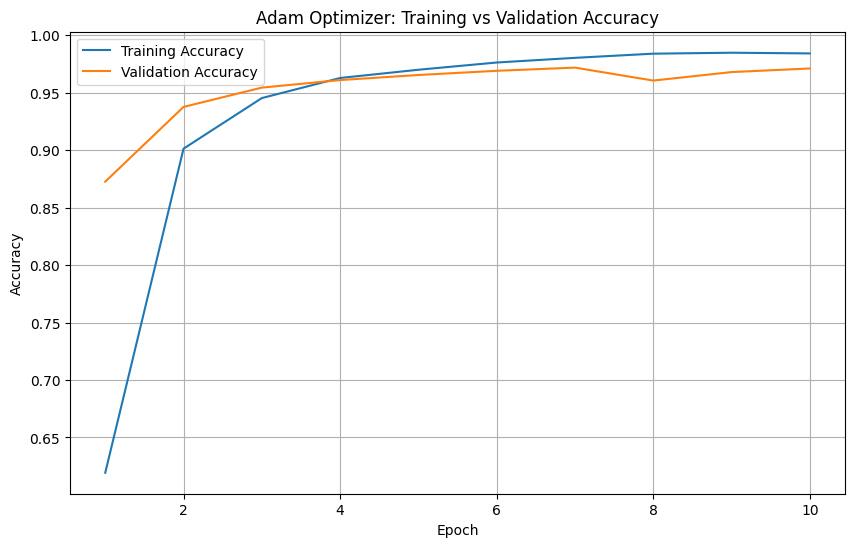

In [54]:
#training acc vs val acc
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Adam Optimizer: Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

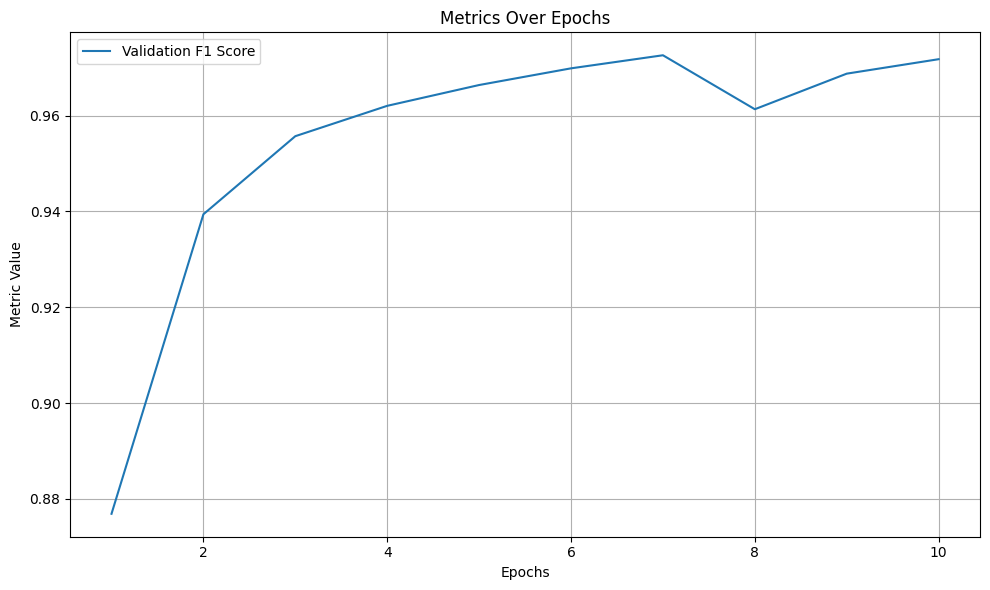

In [55]:
#plot F1score
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, val_f1_score_history, label="Validation F1 Score")

plt.title("Metrics Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

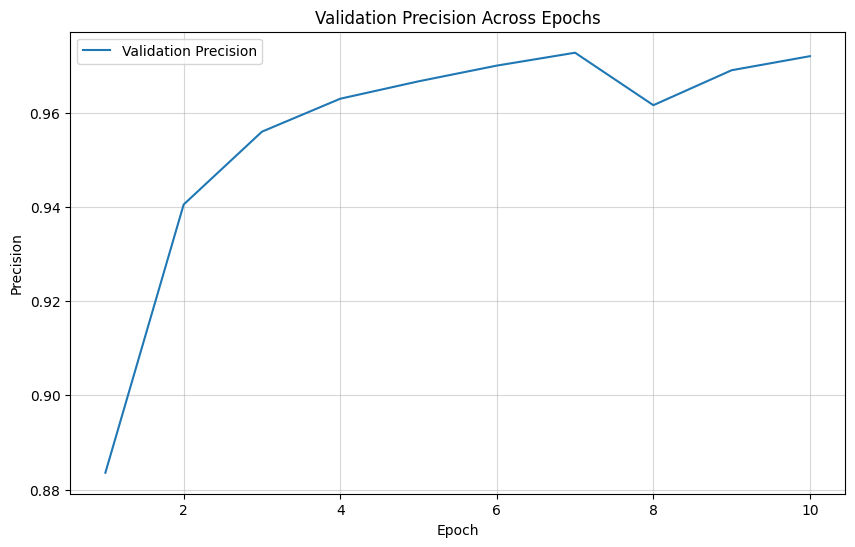

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_precision_history, label="Validation Precision")
plt.title("Validation Precision Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

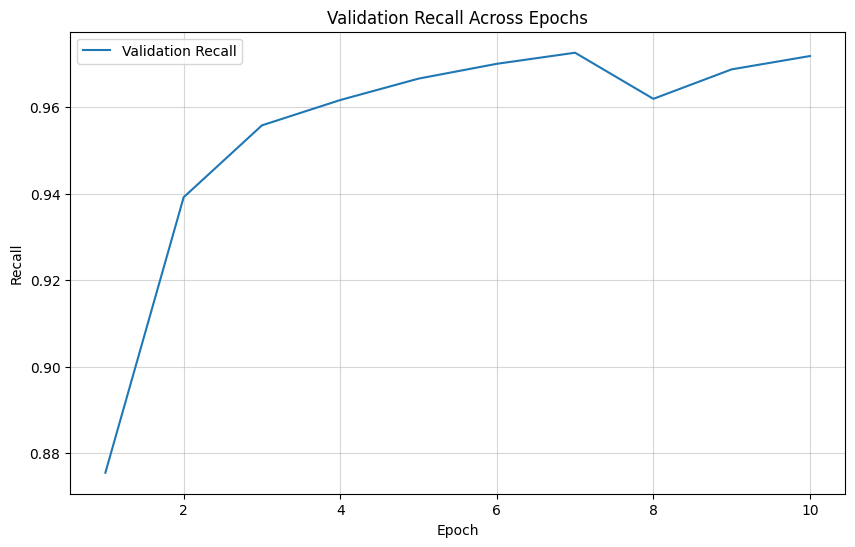

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_recall_history, label="Validation Recall")
plt.title("Validation Recall Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

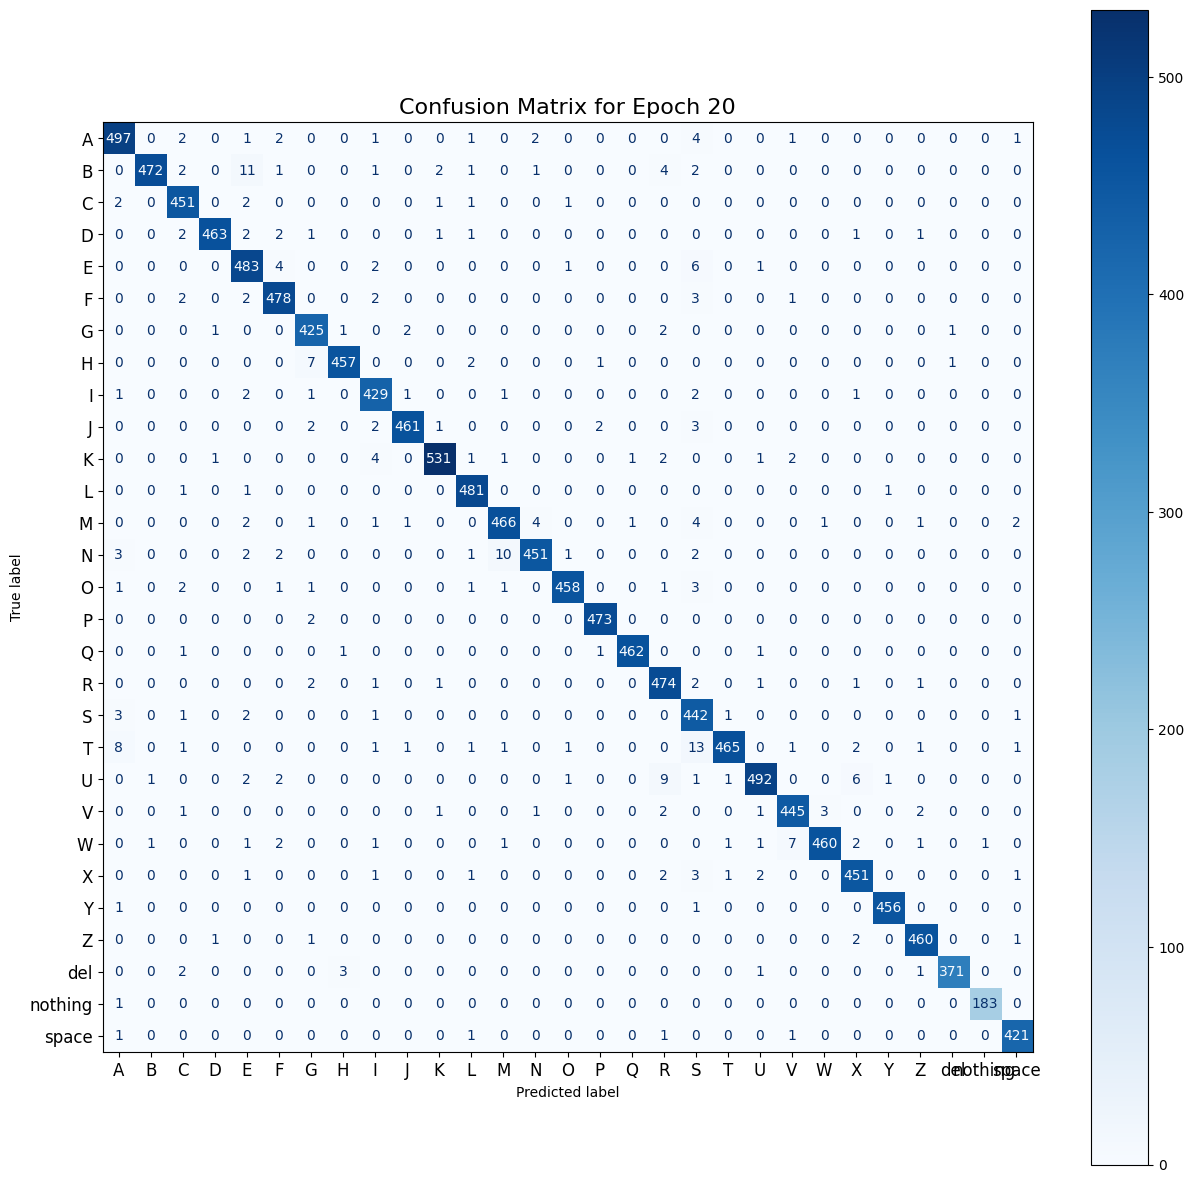

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_loader.dataset.dataset.classes)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"Confusion Matrix for Epoch {epoch + 1}", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [36]:

# save the class asl
torch.save(model.state_dict(), "/content/drive/MyDrive/cnn_model.pth")
print("New model file saved successfully.")



New model file saved successfully.


In [37]:
!ls /content/drive/MyDrive/cnn_model.pth

/content/drive/MyDrive/cnn_model.pth


In [38]:

# load model
def load_model(model_path):
    model = asl(num_classes=29).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=True)
    model.eval()
    return model
    model = load_model("/content/drive/MyDrive/cnn_model.pth")

In [39]:
class_names = [
    "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",
    "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "del", "nothing", "space"
]

In [49]:
#must be the same as the previous preprocessing
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = image.convert("RGB")
    image = transform(image).unsqueeze(0)
    return image.to(device)


In [52]:

# prediction function
def predict(image):
    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)
        return class_names[predicted.item()]
uploaded = files.upload()
if uploaded:
    image_path = list(uploaded.keys())[0]
    image = Image.open(image_path)



Saving image_2025-02-01_124835528.png to image_2025-02-01_124835528.png


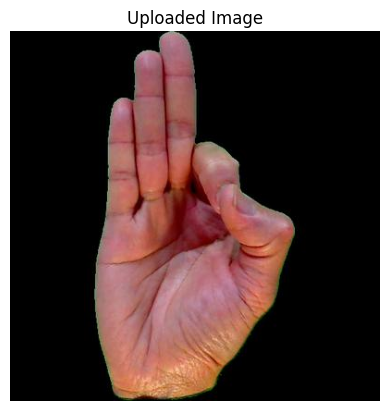

Prediction: F


In [53]:
#predict

plt.imshow(image)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()

processed_image = preprocess_image(image)
prediction = predict(processed_image)
print(f"Prediction: {prediction}")
